In [1]:
import rawpy
import imageio
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import numpy as np
from torchvision import models
from matplotlib import pyplot as plt
import torch
from torchsummary import summary
from collections import defaultdict
import torch.nn.functional as F
import torch
from torchsummary import summary
import torch
import torch.nn as nn
# from loss import dice_loss
from tqdm import tqdm
import random

In [2]:
class SimDataset(Dataset):
    def __init__(self, path, count, transform=None):
        self.flist = []
        self.size = 64
        self.count = count
        self.raw_list = []
        self.rgb_list = []
        for x in tqdm(path.iterdir()):
            if x.is_file():
                self.flist.append(x)
                raw = rawpy.imread(str(x))
                self.raw_list.append(raw.raw_image)
                self.rgb_list.append(raw.postprocess())
#         self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)        
        self.transform = transform
        self.source_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([163], [95]) # imagenet
        ])
        self.target_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
        ])
    def __len__(self):
        return self.count
    
    def __getitem__(self, idx):  
        
        sample_num = idx%len(self.raw_list)
#         raw = rawpy.imread(str(self.flist[idx]))
        raw_image = self.raw_list[sample_num]
        rgb = self.rgb_list[sample_num]
        x, y = random.randint(0,raw_image.shape[0]-self.size-1),random.randint(0,raw_image.shape[1]-self.size-1)
        raw_crop = raw_image[x:x+self.size,y:y+self.size]
        rgb_crop = rgb[x:x+self.size,y:y+self.size]
#         if self.transform:
#             raw_image = self.transform(raw_image.astype(np.float32))
#             rgb = self.transform(rgb)
        
        return [self.source_transform(raw_crop.astype(np.float32)), self.target_transform(rgb_crop)]

# use same transform for train/val for this example

directory = Path('/home/ad/d/distrib/intern_task')
train_set = SimDataset(directory,500)
# val_set = SimDataset(200, transform=trans)

# image_datasets = {
#     'train': train_set, 'val': val_set
# }



50it [00:39,  1.27it/s]


In [3]:
batch_size = 16

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2);

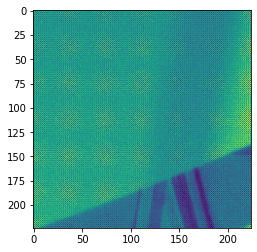

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


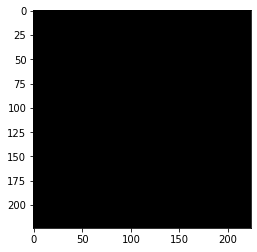

In [3]:
raw, rgb = train_set[0]
plt.imshow(raw.permute(1,2,0))
plt.show()
plt.imshow(rgb.permute(1,2,0))
plt.show()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_model = models.resnet18(pretrained=False)
base_model = base_model.to(device)

# summary(base_model, input_size=(3, 224, 224))


In [5]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(1, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        
        layer3 = self.layer3_1x1(layer3)
#         x = self.upsample(layer3)
#         print("x shape:",x.shape)
#         print("layer3 shape:",layer3.shape)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out



In [6]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(3)
model = model.to(device)

# summary(model, input_size=(3, 224, 224))

In [22]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [7]:
mse_loss = nn.MSELoss()

In [8]:
model = torch.load('resnet18.pt')

In [8]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 3

model = ResNetUNet(num_class).to(device)
# model = torch.load('resnet18.pt')
# freeze backbone layers
# Comment out to finetune further
# for l in model.base_layers:
#     for param in l.parameters():
#         param.requires_grad = False

# optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
# optimizer = optim.Adam(model.parameters(),lr=1e-4)
optimizer = optim.AdamW(model.parameters(),lr=1e-4)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8) 


cuda:0


In [9]:
num_epochs = 100
model.train()  # Set model to training mode
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))

    # Each epoch has a training and validation phase
    for phase in ['train']:

        scheduler.step()
        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])
#             metrics = defaultdict(float)    
#         model.train()  # Set model to training mode
        losses = []
        progress = tqdm(train_dataloader)
        for inputs, labels in progress:
            inputs = inputs.to(device)
            labels = labels.to(device)             

            # forward
            # track history if only in train

            outputs = model(inputs)

            loss = mse_loss(outputs,labels)
            losses.append(loss)

            # Backpropagation
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            progress.set_description(str(loss.item()))




        print("loss:", sum(losses)/len(losses))
        print(optimizer.param_groups[0]['lr'])





/home/ad/venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 0/99
LR 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.8190, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 1/99
LR 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.5492, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 2/99
LR 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.4614, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 3/99
LR 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.3542, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 4/99
LR 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.3093, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 5/99
LR 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.2924, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 6/99
LR 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.2415, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 7/99
LR 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.2356, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 8/99
LR 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.2249, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 9/99
LR 8e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1982, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 10/99
LR 8e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1774, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 11/99
LR 8e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1870, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 12/99
LR 8e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1977, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 13/99
LR 8e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1540, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 14/99
LR 8e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1688, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 15/99
LR 8e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 16/99
LR 8e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1896, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 17/99
LR 8e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1888, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 18/99
LR 8e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1788, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 19/99
LR 6.400000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1935, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 20/99
LR 6.400000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1666, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 21/99
LR 6.400000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1659, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 22/99
LR 6.400000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1806, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 23/99
LR 6.400000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1928, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 24/99
LR 6.400000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1503, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 25/99
LR 6.400000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1675, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 26/99
LR 6.400000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1641, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 27/99
LR 6.400000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1480, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 28/99
LR 6.400000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.2070, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 29/99
LR 5.120000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1533, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 30/99
LR 5.120000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1780, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 31/99
LR 5.120000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1603, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 32/99
LR 5.120000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1680, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 33/99
LR 5.120000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1578, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 34/99
LR 5.120000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1535, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 35/99
LR 5.120000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 36/99
LR 5.120000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1141, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 37/99
LR 5.120000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1426, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 38/99
LR 5.120000000000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1428, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 39/99
LR 4.0960000000000014e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1447, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 40/99
LR 4.0960000000000014e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1548, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 41/99
LR 4.0960000000000014e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1453, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 42/99
LR 4.0960000000000014e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1281, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 43/99
LR 4.0960000000000014e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1250, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 44/99
LR 4.0960000000000014e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1195, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 45/99
LR 4.0960000000000014e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1344, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 46/99
LR 4.0960000000000014e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1501, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 47/99
LR 4.0960000000000014e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1342, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 48/99
LR 4.0960000000000014e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1381, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 49/99
LR 3.2768000000000016e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1699, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 50/99
LR 3.2768000000000016e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1268, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 51/99
LR 3.2768000000000016e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1367, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 52/99
LR 3.2768000000000016e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1386, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 53/99
LR 3.2768000000000016e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1395, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 54/99
LR 3.2768000000000016e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1249, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 55/99
LR 3.2768000000000016e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1194, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 56/99
LR 3.2768000000000016e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1419, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 57/99
LR 3.2768000000000016e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1280, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 58/99
LR 3.2768000000000016e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1387, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 59/99
LR 2.6214400000000015e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1230, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 60/99
LR 2.6214400000000015e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1233, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 61/99
LR 2.6214400000000015e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1200, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 62/99
LR 2.6214400000000015e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1134, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 63/99
LR 2.6214400000000015e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1485, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 64/99
LR 2.6214400000000015e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1312, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 65/99
LR 2.6214400000000015e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1422, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 66/99
LR 2.6214400000000015e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1146, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 67/99
LR 2.6214400000000015e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1559, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 68/99
LR 2.6214400000000015e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1467, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 69/99
LR 2.0971520000000012e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1185, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 70/99
LR 2.0971520000000012e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1201, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 71/99
LR 2.0971520000000012e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1110, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 72/99
LR 2.0971520000000012e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1233, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 73/99
LR 2.0971520000000012e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1165, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 74/99
LR 2.0971520000000012e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1094, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 75/99
LR 2.0971520000000012e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1201, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 76/99
LR 2.0971520000000012e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1361, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 77/99
LR 2.0971520000000012e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1162, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 78/99
LR 2.0971520000000012e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1191, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 79/99
LR 1.677721600000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1010, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 80/99
LR 1.677721600000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1127, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 81/99
LR 1.677721600000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1091, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 82/99
LR 1.677721600000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1138, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 83/99
LR 1.677721600000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1212, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 84/99
LR 1.677721600000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1057, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 85/99
LR 1.677721600000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1200, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 86/99
LR 1.677721600000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1136, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 87/99
LR 1.677721600000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1176, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 88/99
LR 1.677721600000001e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1242, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 89/99
LR 1.3421772800000009e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1166, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 90/99
LR 1.3421772800000009e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1146, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 91/99
LR 1.3421772800000009e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1247, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 92/99
LR 1.3421772800000009e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1137, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 93/99
LR 1.3421772800000009e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1124, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 94/99
LR 1.3421772800000009e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1263, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 95/99
LR 1.3421772800000009e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1176, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 96/99
LR 1.3421772800000009e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1259, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 97/99
LR 1.3421772800000009e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1471, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 98/99
LR 1.3421772800000009e-05


  0%|          | 0/32 [00:00<?, ?it/s]

loss: tensor(0.1086, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 99/99
LR 1.0737418240000008e-05


0.16895189881324768: 100%|██████████| 32/32 [00:06<00:00,  5.20it/s]

loss: tensor(0.1115, device='cuda:0', grad_fn=<DivBackward0>)
1.0737418240000008e-05


In [68]:
scheduler.step()

In [15]:
optimizer.param_groups[0]['lr']

1e-05

In [33]:
torch.save(model,'resnet18_224.pt')

In [39]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

In [24]:
inputs, labels = next(iter(train_dataloader))

In [28]:
out = model(inputs.to(device))

In [36]:
mse_loss(out,labels.to(device))

tensor(0.0581, device='cuda:0', grad_fn=<MseLossBackward>)

In [ ]:
model.eval()

In [40]:
inp, label = train_set[0]
with torch.no_grad():
    out = model(inp.unsqueeze(0).to(device))    
    out_img = reverse_transform(out[0].cpu())
    label_img = reverse_transform(label.cpu())

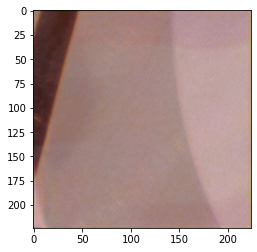

In [41]:
plt.imshow(reverse_transform(out[0].cpu().detach()))

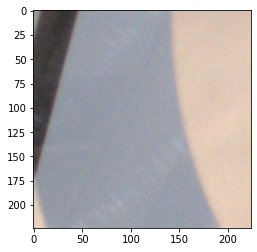

In [42]:
plt.imshow(reverse_transform(label))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


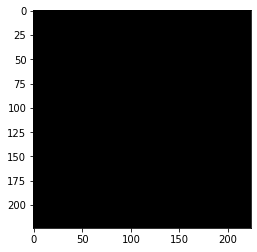

In [34]:
plt.imshow(out[0].cpu().permute(1,2,0).detach().numpy())

In [71]:
label.shape

torch.Size([3, 224, 224])

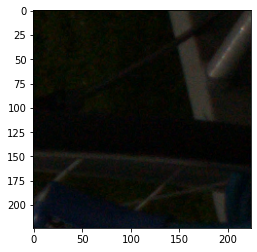

In [13]:
plt.imshow(label_img)

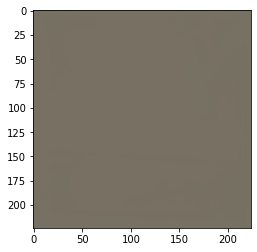

In [14]:
plt.imshow(out_img)